# Public Goods Simulation Visualizer
This notebook reads simulation summary data and snapshot JSON to visualize cooperation dynamics.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import re
import tikzplotlib
import os
from pathlib import Path

os.makedirs("figures", exist_ok=True)
model_to_plot = "A"   # or "B"
This_L = 200

FNAME_RE = re.compile(
    r"r(?P<r0>\d{2})v(?P<sigma>\d{3})_(?P<ftype>[^_]+)_L(?P<L>\d+)_(?P<model>A|B)(?:_tau(?P<tau>\d+))?_summary\.csv$"
)

SEED_DIR_RE = re.compile(r"seed(?P<seed>\d{3})$")

def parse_meta(path: str):
    m = FNAME_RE.search(os.path.basename(path))
    if not m:
        return None
    r0 = int(m.group("r0"))/10.0
    sigma = int(m.group("sigma"))/100.0
    ftype = m.group("ftype")
    L = int(m.group("L"))
    model = m.group("model")
    tau = int(m.group("tau")) if m.group("tau") else 0
    alpha = round(sigma / r0, 4)
    return dict(r0=r0, sigma=sigma, ftype=ftype, L=L, model=model, tau=tau, alpha=alpha)

def parse_seed_from_path(path: str):
    # expect .../data/seedXXX/filename.csv
    p = Path(path)
    # look at the parent directory (seed folder)
    m = SEED_DIR_RE.match(p.parent.name)
    return int(m.group("seed")) if m else None

# --- collect files from all seed folders ---
files = sorted(glob.glob("data/seed*/*_summary.csv"))

rows = []
for f in files:
    meta = parse_meta(f)
    if not meta:
        continue
    if model_to_plot and meta["model"] != model_to_plot:
        continue

    df = pd.read_csv(f)
    if "C" not in df.columns and "Cooperator" in df.columns:
        df = df.rename(columns={"Cooperator":"C"})
    if "time" not in df.columns:
        df["time"] = np.arange(len(df))

    # attach metadata
    for k, v in meta.items():
        df[k] = v

    seed = parse_seed_from_path(f)
    df["seed"] = seed

    rows.append(df)

if not rows:
    raise RuntimeError("No matching CSV files found under data/seedXXX/. Check paths and model_to_plot.")

df_all = pd.concat(rows, ignore_index=True)

# Per-run (per-seed) final state
df_final_all = (
    df_all.sort_values("time")
          .groupby(["r0","sigma","alpha","ftype","L","model","tau","seed"], as_index=False)
          .tail(1)
          .reset_index(drop=True)          # clean 0..N index
          .drop(columns=["time"], errors="ignore")  # remove 'time' if present
)

# If you want to aggregate across seeds later (mean ± std):
# df_final_agg = (df_final
#                 .groupby(["r0","sigma","alpha","ftype","L","model","tau"], as_index=False)
#                 .agg(C_mean=("C","mean"), C_std=("C","std"), n=("C","size")))

df_final_all = df_final_all.reset_index(drop=True)
df_final_all = df_final_all[df_final_all["L"] == This_L].reset_index(drop=True)
df_final_all


,C,mean_payoff,var_payoff,r0,sigma,ftype,L,model,tau,alpha,seed
0,0.000000,0.000000,0.00000,2.0,0.20,uniform,200,A,0,0.1,5
1,0.000000,0.000000,0.00000,3.0,0.60,uniform,200,A,0,0.2,9
2,0.000000,0.000000,0.00000,2.0,0.40,uniform,200,A,0,0.2,5
3,0.000000,0.000000,0.00000,3.0,0.60,uniform,200,A,0,0.2,1
4,0.000000,0.000000,0.00000,3.0,0.30,uniform,200,A,0,0.1,1
...,...,...,...,...,...,...,...,...,...,...,...
975,0.386675,5.139830,24.97120,3.5,1.05,uniform,200,A,0,0.3,9
976,0.099225,1.226850,11.84920,3.0,2.10,uniform,200,A,0,0.7,7
977,0.990100,19.804300,12.52690,5.0,1.50,uniform,200,A,0,0.3,4
978,0.019500,0.231492,2.11784,3.0,1.50,uniform,200,A,0,0.5,19


In [18]:
import numpy as np

group_keys = ["r0","sigma","alpha","ftype","L","model","tau"]

def agg_block(g):
    # C: average final cooperation fraction across seeds
    C_mean = g["C"].mean()

    # mean_payoff: average across seeds
    m_pay = g["mean_payoff"].mean()

    # var_payoff: pooled across seeds (equal L^2 per seed)
    mean_of_vars = g["var_payoff"].mean()
    var_of_means = ((g["mean_payoff"] - m_pay)**2).mean()  # population variance
    v_pay = mean_of_vars + var_of_means

    return pd.Series({
        "C": C_mean,
        "mean_payoff": m_pay,
        "var_payoff": v_pay,
        "n_seeds": g["seed"].nunique()
    })

df_final = df_final_all.groupby(group_keys, as_index=False).apply(agg_block)
df_final = df_final.reset_index(drop=True)
df_final

,r0,sigma,alpha,ftype,L,model,tau,C,mean_payoff,var_payoff,n_seeds
0,2.0,0.20,0.1,uniform,200,A,0,0.000000,0.000000,0.000000,20.0
1,2.0,0.40,0.2,uniform,200,A,0,0.000000,0.000000,0.000000,20.0
2,2.0,0.60,0.3,uniform,200,A,0,0.000000,0.000000,0.000000,20.0
3,2.0,0.80,0.4,uniform,200,A,0,0.000000,0.000000,0.000000,20.0
4,2.0,1.00,0.5,uniform,200,A,0,0.000000,0.000000,0.000000,20.0
5,2.0,1.40,0.7,uniform,200,A,0,0.000000,0.000000,0.000000,20.0
6,2.0,1.80,0.9,uniform,200,A,0,0.000215,0.001898,0.015272,20.0
7,2.5,0.25,0.1,uniform,200,A,0,0.000000,0.000000,0.000000,20.0
8,2.5,0.50,0.2,uniform,200,A,0,0.000000,0.000000,0.000000,20.0
9,2.5,0.75,0.3,uniform,200,A,0,0.000000,0.000000,0.000000,20.0


In [19]:
def _arrays(df, x="r0", y1="C", y2="mean_payoff", v2="var_payoff"):
    x = df[x].to_numpy()
    y_c = df[y1].to_numpy()
    y_m = df[y2].to_numpy()
    y_se = np.sqrt(df[v2].to_numpy())
    return x, y_c, y_m, y_se

def _title(model, alpha=None, L=None, tau=None):
    parts = []
    if alpha is not None: parts.append(rf'$\alpha={alpha:.1f}$')
    if L is not None:     parts.append(rf'$L={int(L)}$')
    if model == "B" and tau is not None:
        parts.append(rf'$\tau={tau}$')
        parts.append(r'$\mathrm{Model\ B}$')
    elif model == "A":
        parts.append(r'$\mathrm{Model\ A}$')
    return r',$\quad$ '.join(parts) if parts else None

def _save(fig, path, tikz=False, tikz_kwargs=None):
    if not path: return
    os.makedirs(os.path.dirname(path), exist_ok=True)
    if tikz:
        import tikzplotlib
        tikzplotlib.save(path, **(tikz_kwargs or {}))
    else:
        fig.savefig(path, dpi=200, bbox_inches='tight')

def fig_name_alpha_tau(model, alpha, L, tau=None, ext="tex"):
    if model == "A":
        return f"alpha_{alpha:.1f}_A.{ext}"
    return f"alpha_{alpha:.1f}_tau{int(tau):05d}_B.{ext}"

# --- main plotting function ---
def plot_dual_axis_by_r0(
    df_subset,
    *,
    alpha_value=None, tau_value=None,          # for title/filename
    save_path=None, save_tikz=False,
    x_col="r0", y1_col="C", y2_col="mean_payoff", y2_var_col="var_payoff",
    model_col="model", L_col="L",
    show=True, return_fig=False,
    y2_ylim=None                                # <-- NEW: force same mean-payoff scale within figure
):
    if df_subset.empty:
        raise ValueError("df_subset is empty")

    model = str(df_subset[model_col].iloc[0])
    L_val = int(df_subset[L_col].iloc[0]) if L_col in df_subset else None
    x, y_c, y_m, y_se = _arrays(df_subset, x_col, y1_col, y2_col, y2_var_col)

    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax1.set_prop_cycle(None)  # predictable colours

    # left: C (blue)
    ax1.plot(x, y_c, marker='o', markersize=1, linewidth=1.5,
             color='tab:blue', label='Cooperator ratio (C)')
    ax1.set_xlabel(r'$r_0$')
    ax1.set_ylabel('Cooperator Ratio', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(-0.05, 1.05)

    # right: mean payoff (red) + SE
    ax2 = ax1.twinx()
    ax2.set_prop_cycle(None)
    ax2.plot(x, y_m, marker='s', markersize=1, linewidth=1.5,
         color='tab:red', linestyle='--', label='Mean payoff')
    ax2.errorbar(x, y_m, yerr=y_se, fmt='none',
                 ecolor='tab:red', alpha=0.5, capsize=3)
    ax2.set_ylabel('Mean Payoff', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # <<< NEW: unify scale if provided, and show zero line if in range >>>
    if y2_ylim is not None:
        lo, hi = y2_ylim
        if np.isfinite(lo) and np.isfinite(hi) and hi > lo:
            ax2.set_ylim(lo, hi)
            if lo < 0 < hi:
                ax2.axhline(0.0, linestyle='--', linewidth=0.8, alpha=0.6, color='tab:red')
    else:
        # keep current auto-scaling; still draw zero if visible
        ylo, yhi = ax2.get_ylim()
        if ylo < 0 < yhi:
            ax2.axhline(0.0, linestyle='--', linewidth=0.8, alpha=0.6, color='tab:red')


    title = _title(model, alpha_value, L_val, tau_value)
    if title: plt.title(title)
    fig.tight_layout()

    _save(fig, save_path, tikz=save_tikz)

    if show:
        from IPython.display import display
        display(fig)
    if return_fig:
        return fig, ax1, ax2
    plt.close(fig)

def render_alpha_plots(df_final, model_to_plot, save_dir="figures", save_tikz=True, show_inline=True):
    import os
    os.makedirs(save_dir, exist_ok=True)

    df = df_final.copy()
    df['tau'] = df.get('tau', 0).fillna(0).astype(int)
    df = df[df['model'] == model_to_plot]
    if df.empty:
        raise ValueError(f"No rows for model={model_to_plot}")

    # --- NEW: precompute per-alpha mean-payoff ranges to unify scale within each LaTeX figure ---
    ranges = {}
    if model_to_plot == 'B':
        # for each alpha, look across all tau>0 panels that will be placed together
        for a, sub_a in df.groupby('alpha'):
            tmp = sub_a[sub_a['tau'] > 0]
            if tmp.empty: 
                continue
            lo = (tmp['mean_payoff'] - np.sqrt(tmp['var_payoff'])).min()
            hi = (tmp['mean_payoff'] + np.sqrt(tmp['var_payoff'])).max()
            if not np.isfinite(lo) or not np.isfinite(hi):
                continue
            pad = 0.05 * (hi - lo) if hi > lo else 0.1 * max(1.0, abs(hi))
            ranges[float(a)] = (lo - pad, hi + pad)
    else:
        # Model A: still compute per-alpha range (single panel, but harmless/consistent)
        for a, sub_a in df.groupby('alpha'):
            lo = (sub_a['mean_payoff'] - np.sqrt(sub_a['var_payoff'])).min()
            hi = (sub_a['mean_payoff'] + np.sqrt(sub_a['var_payoff'])).max()
            if not np.isfinite(lo) or not np.isfinite(hi):
                continue
            pad = 0.05 * (hi - lo) if hi > lo else 0.1 * max(1.0, abs(hi))
            ranges[float(a)] = (lo - pad, hi + pad)

    # Grouping scheme: A -> by alpha; B -> by (alpha, tau>0)
    keys = ['alpha'] if model_to_plot == 'A' else ['alpha', 'tau']

    n = 0
    for key_vals, sub in df.groupby(keys, sort=True):
        if model_to_plot == 'A':
            alpha, tau = float(key_vals[0]), 0
        else:
            alpha, tau = float(key_vals[0]), int(key_vals[1])
            if tau <= 0:
                continue

        sub = sub.sort_values('r0')
        if sub.empty:
            continue
        L_val = int(sub['L'].iloc[0])

        save_path = os.path.join(
            save_dir,
            fig_name_alpha_tau(model_to_plot, alpha, L_val, tau=tau, ext="tex")
        )

        # <<< NEW: pass the unified mean-payoff y-lims for this alpha >>>
        y2_ylim = ranges.get(alpha, None)

        plot_dual_axis_by_r0(
            sub,
            alpha_value=alpha,
            tau_value=tau,
            save_path=save_path,
            save_tikz=save_tikz,
            show=show_inline,
            y2_ylim=y2_ylim                     # <-- key line
        )
        n += 1

    print(f"[done] generated {n} plot(s) for model {model_to_plot} → {save_dir}")


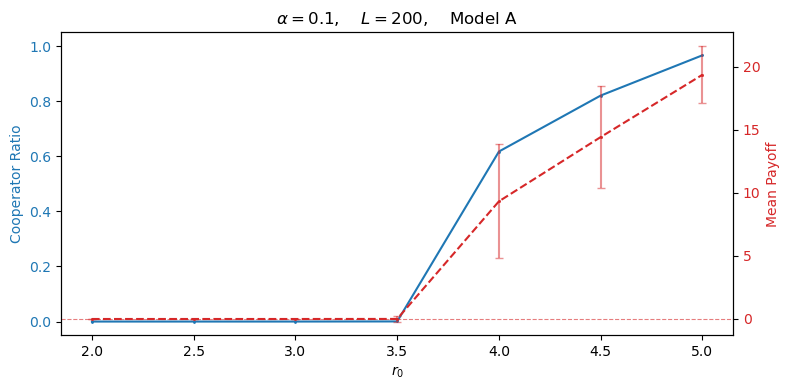

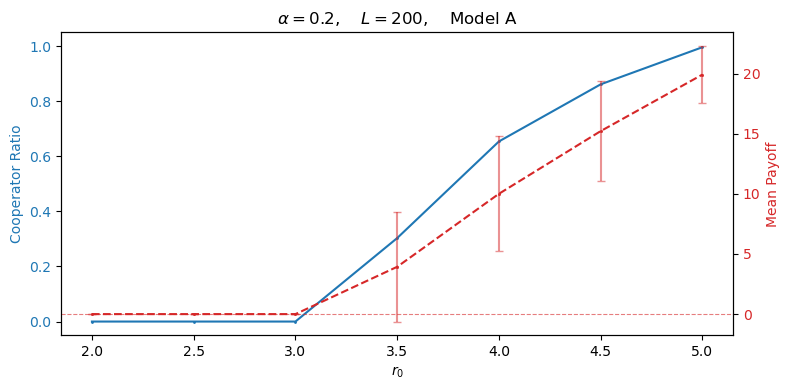

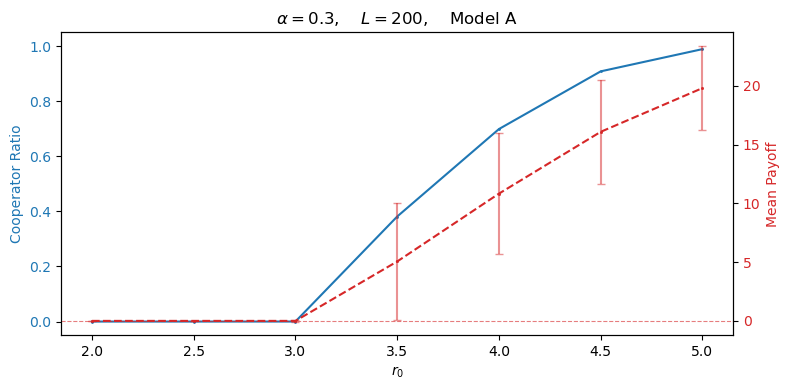

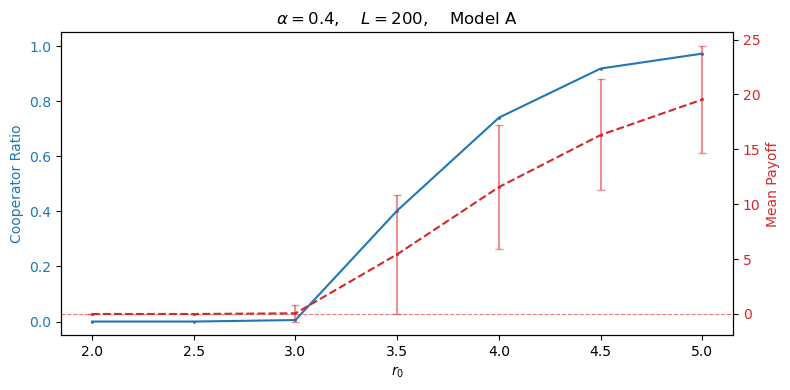

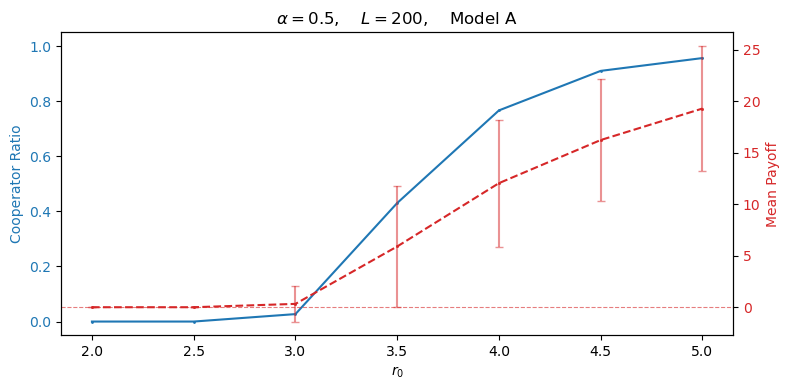

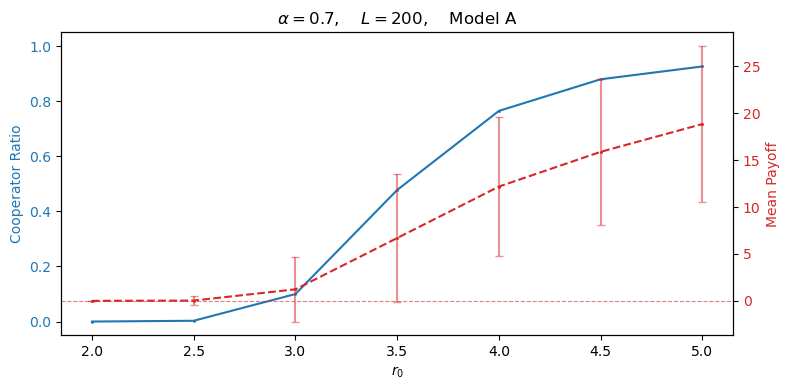

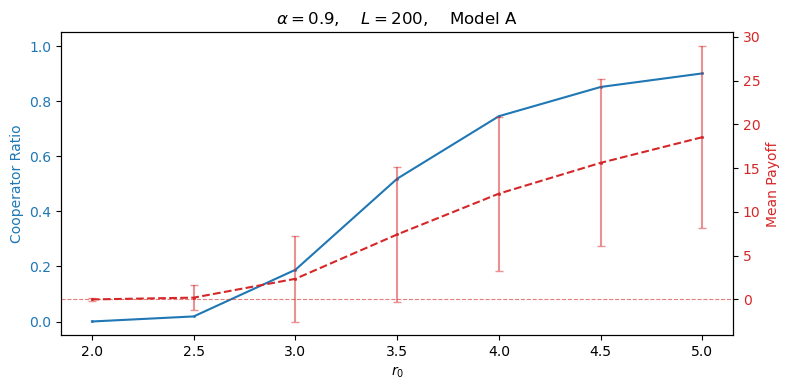

[done] generated 7 plot(s) for model A → figures/A_seed_20_L200_T10K


In [20]:
if This_L == 200:
    dir_name = "figures/" + model_to_plot + "_seed_20_L"+ str(This_L) + "_T10K"
else:
    dir_name = "figures/" + model_to_plot + "_seed_20"

render_alpha_plots(df_final, model_to_plot, save_dir=dir_name, save_tikz=True)

In [24]:
# ---------------------------
# CONSISTENT STYLE MAPPINGS
# ---------------------------
TAU_STYLE = {
    1:   dict(color=None, linestyle='-',  marker='o'),
    10:  dict(color=None, linestyle='--', marker='s'),
    100: dict(color=None, linestyle='-.', marker='D'),
    1000:dict(color=None, linestyle=':',  marker='^'),
}
ALPHA_STYLE = {
    0.1: dict(color=None, linestyle='-',  marker='o'),
    0.3: dict(color=None, linestyle='--', marker='s'),
    0.5: dict(color=None, linestyle='-.', marker='D'),
    0.7: dict(color=None, linestyle=':',  marker='^'),
    0.9: dict(color=None, linestyle=(0,(1,1)), marker='v'),  # dotted-ish fallback
}

def _assign_palette(keys, style_dict):
    """Fill in missing colors from current rcParams cycle, keep per-key consistency."""
    palette = plt.rcParams['axes.prop_cycle'].by_key().get('color', [])
    # repeat palette if needed
    while len(palette) < len(keys):
        palette += palette
    for i, k in enumerate(sorted(keys)):
        if style_dict.get(k, {}).get('color') is None:
            style_dict.setdefault(k, {})
            style_dict[k]['color'] = palette[i]
    return style_dict

# -------------------------------------------
# (A) MULTI-τ PER α (C-only) with fixed map
# -------------------------------------------
def plot_C_by_r0_multi_tau(
    df_alpha,                                # df: single alpha, model B, many τ
    *,
    alpha_value=None,
    tau_values=(1, 10, 100, 1000),
    save_path=None,
    save_tikz=False,
    x_col="r0", yC_col="C",
    model_col="model", L_col="L",
    show=True, return_fig=False,
    ylim=(-0.05, 1.05),
    markersize=2.2, linewidth=1.8
):
    if df_alpha.empty:
        raise ValueError("df_alpha is empty")
    df_alpha = df_alpha.copy()
    df_alpha['tau'] = df_alpha.get('tau', 0).fillna(0).astype(int)

    model = str(df_alpha[model_col].iloc[0])
    assert model == "B", "plot_C_by_r0_multi_tau is for Model B."
    L_val = int(df_alpha[L_col].iloc[0]) if L_col in df_alpha else None

    taus_in_df = sorted(set(int(t) for t in df_alpha['tau'] if int(t) > 0))
    taus = [int(t) for t in tau_values if int(t) in taus_in_df]
    if not taus:
        raise ValueError("No matching τ in df_alpha for the requested tau_values.")

    # ensure colors for these tau values
    _assign_palette(taus, TAU_STYLE)

    fig, ax = plt.subplots(figsize=(8.5, 4.5))
    ax.set_xlabel(r'$r_0$')
    ax.set_ylabel('Cooperator Ratio')
    if ylim is not None:
        ax.set_ylim(*ylim)

    handles, labels = [], []
    for tau in taus:
        sub = df_alpha[df_alpha['tau'] == tau].sort_values(x_col)
        if sub.empty:
            continue
        x = sub[x_col].to_numpy()
        yC = sub[yC_col].to_numpy()

        st = TAU_STYLE[tau]
        h, = ax.plot(
            x, yC,
            marker=st['marker'], markersize=markersize,
            linewidth=linewidth, color=st['color'], linestyle=st['linestyle']
        )
        handles.append(h)
        labels.append(rf'$\tau={tau}$')

    # title: α, L, Model B
    title = r',$\quad$ '.join(filter(None, [
        rf'$\alpha={alpha_value:.1f}$' if alpha_value is not None else None,
        rf'$L={int(L_val)}$' if L_val is not None else None,
        r'$\mathrm{Model\ B}$'
    ]))
    if title:
        ax.set_title(title)

    ax.legend(handles, labels, title=r'$\tau$', loc='best', frameon=True)
    fig.tight_layout()
    _save(fig, save_path, tikz=save_tikz)

    if show:
        from IPython.display import display
        display(fig)
    if return_fig:
        return fig, ax
    plt.close(fig)

# ----------------------------------------------------------
# (B) MULTI-α PER τ (C-only) → what you asked for: 4 graphs
# ----------------------------------------------------------
def fig_name_tau_allalpha_C(model, tau, L, ext="tex"):
    assert model == "B"
    return f"tau_{int(tau):05d}_B_allalpha_C.{ext}"

def plot_C_by_r0_multi_alpha(
    df_tau,                                   # df: single τ, model B, many α
    *,
    tau_value=None,
    alpha_values=(0.1, 0.3, 0.5, 0.7, 0.9),
    save_path=None,
    save_tikz=False,
    x_col="r0", yC_col="C",
    model_col="model", L_col="L", alpha_col="alpha",
    show=True, return_fig=False,
    ylim=(-0.05, 1.05),
    markersize=2.2, linewidth=1.8
):
    if df_tau.empty:
        raise ValueError("df_tau is empty")
    df_tau = df_tau.copy()
    df_tau['tau'] = df_tau.get('tau', 0).fillna(0).astype(int)

    model = str(df_tau[model_col].iloc[0])
    assert model == "B", "plot_C_by_r0_multi_alpha is for Model B."
    L_val = int(df_tau[L_col].iloc[0]) if L_col in df_tau else None
    tau_in_df = int(df_tau['tau'].iloc[0]) if 'tau' in df_tau else None
    if tau_value is None:
        tau_value = tau_in_df

    # filter to the single τ slice
    df_tau = df_tau[df_tau['tau'] == int(tau_value)]
    if df_tau.empty:
        raise ValueError(f"No rows for τ={tau_value}")

    # which alphas exist?
    alphas_in_df = sorted(set(float(a) for a in df_tau[alpha_col]))
    alphas = [float(a) for a in alpha_values if float(a) in alphas_in_df]
    if not alphas:
        raise ValueError("No matching α in df_tau for the requested alpha_values.")

    # ensure colors for these alpha values
    _assign_palette(alphas, ALPHA_STYLE)

    fig, ax = plt.subplots(figsize=(8.5, 4.5))
    ax.set_xlabel(r'$r_0$')
    ax.set_ylabel('Cooperator Ratio')
    if ylim is not None:
        ax.set_ylim(*ylim)

    handles, labels = [], []
    for a in alphas:
        sub = df_tau[np.isclose(df_tau[alpha_col].astype(float), a)].sort_values(x_col)
        if sub.empty:
            continue
        x = sub[x_col].to_numpy()
        yC = sub[yC_col].to_numpy()

        st = ALPHA_STYLE[a]
        h, = ax.plot(
            x, yC,
            marker=st['marker'], markersize=markersize,
            linewidth=linewidth, color=st['color'], linestyle=st['linestyle']
        )
        handles.append(h)
        labels.append(rf'$\alpha={a:.1f}$')

    # title: τ, L, Model B
    title = r',$\quad$ '.join(filter(None, [
        rf'$\tau={int(tau_value)}$' if tau_value is not None else None,
        rf'$L={int(L_val)}$' if L_val is not None else None,
        r'$\mathrm{Model\ B}$'
    ]))
    if title:
        ax.set_title(title)

    ax.legend(handles, labels, title=r'$\alpha$', loc='best', frameon=True)
    fig.tight_layout()
    _save(fig, save_path, tikz=save_tikz)

    if show:
        from IPython.display import display
        display(fig)
    if return_fig:
        return fig, ax
    plt.close(fig)

# ---------------------------
# DRIVERS (batch rendering)
# ---------------------------
def render_alpha_plots_all_tau_C(df_final, save_dir="figures", save_tikz=True, show_inline=True):
    """Existing driver (per-α, overlay τ)."""
    import os
    os.makedirs(save_dir, exist_ok=True)
    df = df_final.copy()
    df['tau'] = df.get('tau', 0).fillna(0).astype(int)
    df = df[df['model'] == 'B']
    if df.empty:
        raise ValueError("No rows for model=B")
    n = 0
    for a, sub_a in df.groupby('alpha', sort=True):
        a = float(a)
        sub_a = sub_a.sort_values('r0')
        if sub_a.empty: continue
        L_val = int(sub_a['L'].iloc[0])
        save_path = os.path.join(save_dir, f"alpha_{a:.1f}_B_alltau_C.tex")
        plot_C_by_r0_multi_tau(
            sub_a, alpha_value=a,
            tau_values=(1, 10, 100, 1000),
            save_path=save_path, save_tikz=save_tikz, show=show_inline
        )
        n += 1
    print(f"[done] generated {n} C-only multi-τ plot(s) for Model B → {save_dir}")

def render_tau_plots_multi_alpha_C(
    df_final, save_dir="figures", save_tikz=True, show_inline=True,
    tau_values=(1, 10, 100, 1000),
    alpha_values=(0.1, 0.3, 0.5, 0.7, 0.9)
):
    """NEW driver: 4 graphs (per-τ) overlaying the five α curves."""
    import os
    os.makedirs(save_dir, exist_ok=True)
    df = df_final.copy()
    df['tau'] = df.get('tau', 0).fillna(0).astype(int)
    df = df[df['model'] == 'B']
    if df.empty:
        raise ValueError("No rows for model=B")

    # lock in palettes for both sets up-front
    _assign_palette([int(t) for t in tau_values], TAU_STYLE)
    _assign_palette([float(a) for a in alpha_values], ALPHA_STYLE)

    n = 0
    for tau in tau_values:
        sub_t = df[df['tau'] == int(tau)].sort_values('r0')
        if sub_t.empty:
            continue
        L_val = int(sub_t['L'].iloc[0])
        save_path = os.path.join(save_dir, fig_name_tau_allalpha_C('B', tau, L_val, ext="tex"))
        plot_C_by_r0_multi_alpha(
            sub_t,
            tau_value=int(tau),
            alpha_values=alpha_values,
            save_path=save_path, save_tikz=save_tikz, show=show_inline
        )
        n += 1
    print(f"[done] generated {n} C-only multi-α plot(s) for τ panels → {save_dir}")


# -------- filenames --------
def fig_name_modelA_allalpha_C(L, ext="tex"):
    return f"L_{int(L)}_A_allalpha_C.{ext}"

# -------- single figure: Model A, overlay multiple α --------
def plot_C_by_r0_multi_alpha_modelA(
    df_A, *,
    alpha_values=(0.1, 0.3, 0.5, 0.7, 0.9),
    save_path=None, save_tikz=True,
    x_col="r0", yC_col="C", alpha_col="alpha", L_col="L", model_col="model",
    show=True, return_fig=False,
    ylim=(-0.05, 1.05),
    markersize=2.2, linewidth=1.8
):
    if df_A.empty:
        raise ValueError("df_A is empty")
    df_A = df_A.copy()
    model = str(df_A[model_col].iloc[0])
    assert model == "A", "Use this function with Model A data."
    L_val = int(df_A[L_col].iloc[0]) if L_col in df_A else None

    # lock palette for these alphas
    _assign_palette([float(a) for a in alpha_values], ALPHA_STYLE)

    # figure
    fig, ax = plt.subplots(figsize=(8.5, 4.5))
    ax.set_xlabel(r'$r_0$')
    ax.set_ylabel('Cooperator Ratio')
    if ylim is not None:
        ax.set_ylim(*ylim)

    handles, labels = [], []
    for a in alpha_values:
        a = float(a)
        sub = df_A[np.isclose(df_A[alpha_col].astype(float), a)].sort_values(x_col)
        if sub.empty:
            continue
        x = sub[x_col].to_numpy()
        yC = sub[yC_col].to_numpy()

        st = ALPHA_STYLE[a]
        h, = ax.plot(
            x, yC,
            marker=st['marker'], markersize=markersize,
            linewidth=linewidth, color=st['color'], linestyle=st['linestyle']
        )
        handles.append(h)
        labels.append(rf'$\alpha={a:.1f}$')

    # title: L, Model A (no r0)
    title = r',$\quad$ '.join(filter(None, [
        rf'$L={int(L_val)}$' if L_val is not None else None,
        r'$\mathrm{Model\ A}$'
    ]))
    if title:
        ax.set_title(title)

    ax.legend(handles, labels, title=r'$\alpha$', loc='best', frameon=True)
    fig.tight_layout()
    _save(fig, save_path, tikz=save_tikz)

    if show:
        from IPython.display import display
        display(fig)
    if return_fig:
        return fig, ax
    plt.close(fig)

# -------- driver: one figure per L (if multiple L present) --------
def render_modelA_allalpha_C(
    df_final, save_dir="figures", save_tikz=True, show_inline=True,
    alpha_values=(0.1, 0.3, 0.5, 0.7, 0.9)
):
    import os
    os.makedirs(save_dir, exist_ok=True)
    df = df_final.copy()
    df = df[df['model'] == 'A']
    if df.empty:
        raise ValueError("No rows for model=A")

    # lock alpha palette once
    _assign_palette([float(a) for a in alpha_values], ALPHA_STYLE)

    n = 0
    for L_val, subL in df.groupby('L', sort=True):
        subL = subL.sort_values('r0')
        if subL.empty:
            continue
        save_path = os.path.join(save_dir, fig_name_modelA_allalpha_C(L_val, ext="tex"))
        plot_C_by_r0_multi_alpha_modelA(
            subL,
            alpha_values=alpha_values,
            save_path=save_path,
            save_tikz=save_tikz,
            show=show_inline
        )
        n += 1
    print(f"[done] generated {n} C-only multi-α Model A plot(s) → {save_dir}")



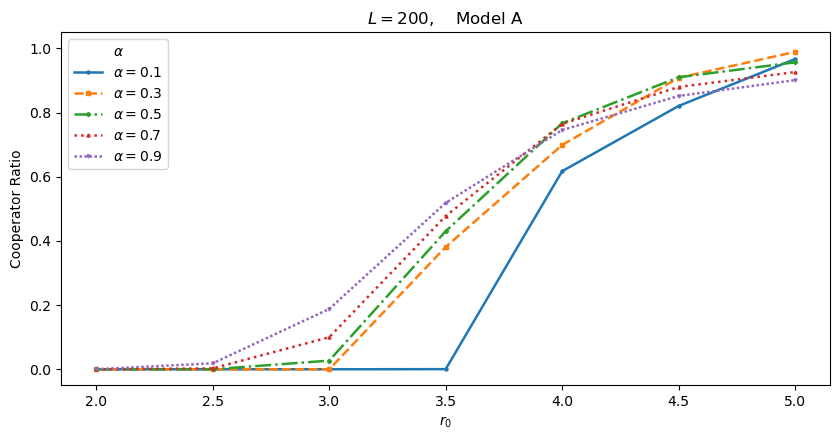

[done] generated 1 C-only multi-α Model A plot(s) → figures/A_seed_20_L200_T10K_4in1


In [25]:
if This_L == 200:
    dir_name = "figures/" + model_to_plot + "_seed_20_L"+ str(This_L) + "_T10K_4in1"
else:
    dir_name = "figures/" + model_to_plot + "_seed_20"

if model_to_plot == 'A':
    render_modelA_allalpha_C(df_final, save_dir=dir_name, save_tikz=True)
else:
    render_tau_plots_multi_alpha_C(df_final, save_dir=dir_name, save_tikz=True)